In [1]:
from dotenv import  load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [2]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun() 

In [3]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (build_resource_service, get_gmail_credentials)

credentials = get_gmail_credentials(
    token_file="./google/token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json"
)

api_resource = build_resource_service(credentials=credentials)

gmail_toolkit = GmailToolkit(api_resource=api_resource)

gmail_tool_list = gmail_toolkit.get_tools()

gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x10dbecbd0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x10dbecbd0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x10dbecbd0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x10dbecbd0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x10dbecbd0>)]

In [4]:
from langchain_classic.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)

loaded_tool_list

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000))]

In [5]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool


embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'real_estate_tax2',
    persist_directory = './real_estate_tax_collection2'
)
retriever = vector_store.as_retriever(search_kwargs={'k':3})


retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retreiver',
    description='Contains information about real estate tax up to December 2025'
)

In [6]:
from langgraph.prebuilt import ToolNode

tool_list = [ search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)  

tool_node = ToolNode(tool_list) 


In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [8]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [9]:
# def should_continue(state: MessagesState):
#     messages = state['messages']
#     last_ai_message = messages[-1]
    
#     if last_ai_message.tool_calls:
#         return 'tools'
#     return 'end'

In [10]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tool_node', tool_node)

In [11]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    tools_condition,
    {
        'tools': 'tool_node',
        '__end__': END
    },
)

graph_builder.add_edge('tool_node', 'agent')

In [12]:
graph = graph_builder.compile()

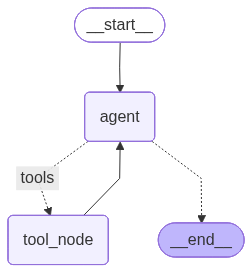

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage

query='How much 1 USD by Korean Won? Find the price and Send email to ksz18601@gmail.com'

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

How much 1 USD by Korean Won? Find the price and Send email to ksz18601@gmail.com
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_BEDngnVUrN0pV6Fcv0SZX0fL)
 Call ID: call_BEDngnVUrN0pV6Fcv0SZX0fL
  Args:
    query: 1 USD to Korean Won exchange rate
  create_gmail_draft (call_WdN2oUETvITxezNa6QoZFtFj)
 Call ID: call_WdN2oUETvITxezNa6QoZFtFj
  Args:
    message: I am fetching the current exchange rate for 1 USD to Korean Won. I will update you shortly.
    to: ['ksz18601@gmail.com']
    subject: Exchange Rate Inquiry
================================= Tool Message =================================
Name: create_gmail_draft

Draft created. Draft Id: r3628305172598731128
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_wka9DiQZfnTDZWruNlBlpTSf)
 Call ID: call_wka9DiQZfnTD

In [15]:
from langchain_core.messages import HumanMessage

query='please Summarize the Conclusion part of `attention Is All You Need` and Send email to ksz18601@gmail.com'

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

please Summarize the Conclusion part of `attention Is All You Need` and Send email to ksz18601@gmail.com
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_vgg8ZiOzS1TZUX0nckpmsRqF)
 Call ID: call_vgg8ZiOzS1TZUX0nckpmsRqF
  Args:
    query: attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specific

In [16]:
from langchain_core.messages import HumanMessage

query='15억원짜리 집을 소유하고 있을 경우의 종합부동산세를 계산해주세요. 그리고, 바로 ksz18601@gmail.com로 이메일을 전송해주세요.'

for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

15억원짜리 집을 소유하고 있을 경우의 종합부동산세를 계산해주세요. 그리고, 바로 ksz18601@gmail.com로 이메일을 전송해주세요.
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retreiver (call_2u8QprtoxdKlFLyWOiz8aHMR)
 Call ID: call_2u8QprtoxdKlFLyWOiz8aHMR
  Args:
    query: 15억원짜리 집 종합부동산세
================================= Tool Message =================================
Name: real_estate_tax_retreiver

납세의무자가 2주택 이하를 소유한 경우

| 과세표준              | 세율                                  |
|---------------------|-------------------------------------|
| 3억 원 이하           | 1천분의 5                              |
| 3억 원 초과 6억 원 이하 | 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)  |
| 6억 원 초과 12억 원 이하 | 360만 원 + (6억 원을 초과하는 금액의 1천분의 10) |
| 12억 원 초과 25억 원 이하 | 960만 원 + (12억 원을 초과하는 금액의 1천분의 13)|
| 25억 원 초과 50억 원 이하 | 2천650만 원 + (25억 원을 초과하는 금액의 1천분의 15)|
| 50억 원 초과 94억 원 이하 | 6천400만 원 + (50억 원을 초과하는 금액의 1천분의 20)|
|